In [1]:
%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"

import torch
import torchopt
from einops import rearrange, reduce
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct

# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


dataset = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-an-data/Chunxu/ese5934_project/data"),
    transform=data_transform,
    challenge="multicoil",
)

# Grid Field (Voxel Representation)

In [39]:
from ese5934_project.models.GridField import Grid

optimizer = torchopt.adam(lr=0.1)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Grid((640, 368), mean, std)
# field.grid =

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [13]:
print(masked_kspace.shape, mask.shape, csm.shape)

torch.Size([15, 640, 368, 2]) torch.Size([1, 1, 368, 1]) torch.Size([15, 640, 368, 2])


In [53]:
params, image_list = reconstruct(
    field,
    torch.rand(1, 2),
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=400,
    device=torch.device("cuda:0"),
)

iteration 1, dc_loss: 0.018170848488807678, tv_loss: 0.016728848218917847
iteration 2, dc_loss: 0.01780579797923565, tv_loss: 0.017365824431180954
iteration 3, dc_loss: 0.017713604494929314, tv_loss: 0.017447078600525856
iteration 4, dc_loss: 0.017689170315861702, tv_loss: 0.017288552597165108
iteration 5, dc_loss: 0.017725607380270958, tv_loss: 0.01715702936053276
iteration 6, dc_loss: 0.017783934250473976, tv_loss: 0.017157454043626785
iteration 7, dc_loss: 0.017811276018619537, tv_loss: 0.01712280884385109
iteration 8, dc_loss: 0.017795106396079063, tv_loss: 0.017080962657928467
iteration 9, dc_loss: 0.017756035551428795, tv_loss: 0.017112113535404205
iteration 10, dc_loss: 0.017717629671096802, tv_loss: 0.017146825790405273
iteration 11, dc_loss: 0.017691079527139664, tv_loss: 0.017161227762699127
iteration 12, dc_loss: 0.01767747476696968, tv_loss: 0.017162367701530457
iteration 13, dc_loss: 0.017675206065177917, tv_loss: 0.017154879868030548
iteration 14, dc_loss: 0.0176832433789

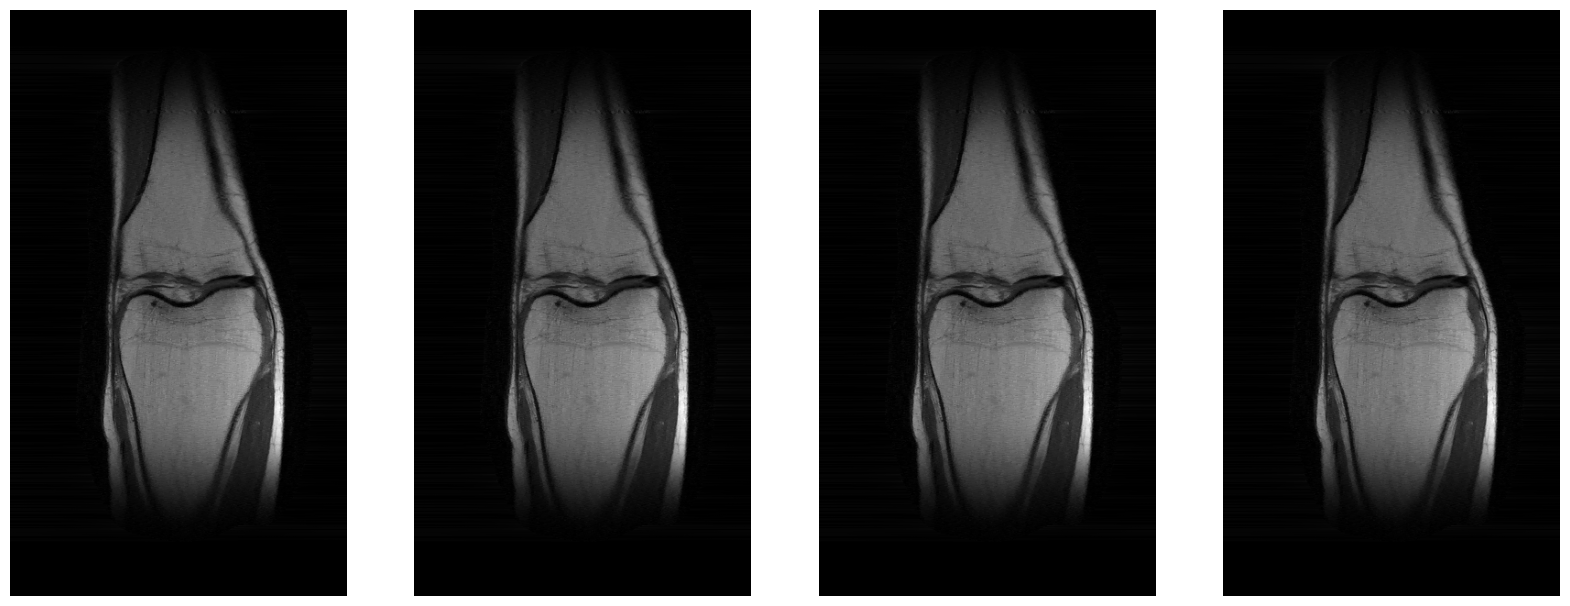

In [54]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list[-4:]):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")  # , vmin=0, vmax=2)
    axs[i % 5].axis("off")

# SIREN

In [108]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("cuda:0")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=256,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-4)
# 1e-4 1.092077389
# 1e-3 0.08540542

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [113]:
params, image_list = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=2000,
    device=device,
)

iteration 1, dc_loss: 0.0213047843426466, tv_loss: 0.016917837783694267
iteration 2, dc_loss: 0.1363963931798935, tv_loss: 0.018340839073061943
iteration 3, dc_loss: 0.04204075410962105, tv_loss: 0.018947042524814606
iteration 4, dc_loss: 0.04422040283679962, tv_loss: 0.018855664879083633
iteration 5, dc_loss: 0.055190738290548325, tv_loss: 0.018723389133810997
iteration 6, dc_loss: 0.0518495999276638, tv_loss: 0.018643897026777267
iteration 7, dc_loss: 0.04533035680651665, tv_loss: 0.018433712422847748
iteration 8, dc_loss: 0.03811899572610855, tv_loss: 0.018191669136285782
iteration 9, dc_loss: 0.03607150912284851, tv_loss: 0.018009193241596222
iteration 10, dc_loss: 0.034913320094347, tv_loss: 0.017961841076612473
iteration 11, dc_loss: 0.03387008607387543, tv_loss: 0.017949096858501434
iteration 12, dc_loss: 0.03267710283398628, tv_loss: 0.017901787534356117
iteration 13, dc_loss: 0.03148278966546059, tv_loss: 0.017840130254626274
iteration 14, dc_loss: 0.030489111319184303, tv_los

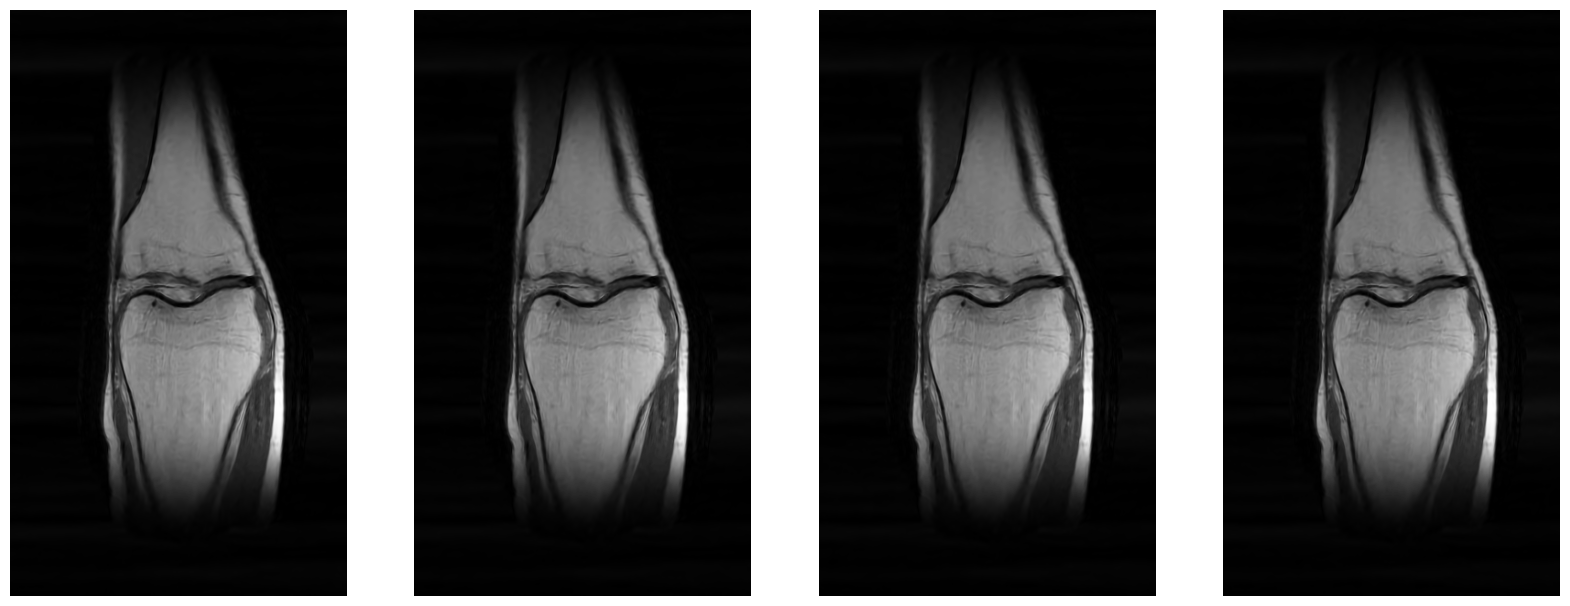

In [114]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list[-4:]):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")  # , vmin=0, vmax=2)
    axs[i % 5].axis("off")

# DictField

In [ ]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("cuda:0")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=256,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-4)
# 1e-4 1.092077389
# 1e-3 0.08540542

In [ ]:
params, image_list = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=2000,
    device=device,
)